In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import random

# Set seed global untuk reproducibility
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Path dataset
dataset_dir = 'D:\\Semester 6\\AI\\Artificial_Inteligence\\PlantVillage'

# Parameter
batch_size = 16
img_size = (128, 128)

# 1. Load data (resize otomatis)
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed  # agar shuffle konsisten
)

# Ambil data dan label numpy
data, labels = [], []
for img_batch, label_batch in full_dataset:
    data.append(img_batch.numpy())
    labels.append(label_batch.numpy())
data = np.concatenate(data)
labels = np.concatenate(labels)

# 2. Normalisasi data pixel dari [0,255] ke [0,1]
data = data / 255.0
data

Found 2152 files belonging to 3 classes.


array([[[[0.51960784, 0.44117647, 0.4764706 ],
         [0.54019606, 0.4617647 , 0.4970588 ],
         [0.56666666, 0.4882353 , 0.5235294 ],
         ...,
         [0.55784315, 0.50686276, 0.5421569 ],
         [0.5901961 , 0.5392157 , 0.5745098 ],
         [0.5745098 , 0.5235294 , 0.5588235 ]],

        [[0.5205882 , 0.44215685, 0.47745097],
         [0.5117647 , 0.43333334, 0.46862745],
         [0.59117645, 0.5127451 , 0.5480392 ],
         ...,
         [0.57843137, 0.527451  , 0.5627451 ],
         [0.5833333 , 0.5323529 , 0.56764704],
         [0.5980392 , 0.5470588 , 0.58235294]],

        [[0.56764704, 0.48921567, 0.5245098 ],
         [0.5264706 , 0.4480392 , 0.48333332],
         [0.5392157 , 0.46078432, 0.49607843],
         ...,
         [0.5617647 , 0.5107843 , 0.54607844],
         [0.55      , 0.4990196 , 0.53431374],
         [0.56764704, 0.51666665, 0.55196077]],

        ...,

        [[0.6627451 , 0.6039216 , 0.6313726 ],
         [0.7137255 , 0.654902  , 0.68235296]

In [2]:
# 3. Split data jadi train 80%, val 10%, test 10%
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.2, random_state=seed, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed, shuffle=True)

# 4. Buat fungsi augmentasi sederhana (flip horizontal)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

# 5. Buat tf.data.Dataset untuk train, val, test
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000, seed=seed).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Terapkan augmentasi hanya ke train dataset
train_dataset = train_dataset.map(augment)

# Prefetch untuk performa
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [3]:
# Definisikan model CNN 
input_shape = (128, 128, 3)
num_classes = 3

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

C:\Users\BSOK AKU\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Training model
epochs = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5572 - loss: 0.9596 - val_accuracy: 0.8419 - val_loss: 0.4985
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.8471 - loss: 0.3861 - val_accuracy: 0.9070 - val_loss: 0.2869
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.8946 - loss: 0.2840 - val_accuracy: 0.9488 - val_loss: 0.1925
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9304 - loss: 0.1726 - val_accuracy: 0.9349 - val_loss: 0.1867
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9418 - loss: 0.1319 - val_accuracy: 0.9349 - val_loss: 0.1496
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9551 - loss: 0.1111 - val_accuracy: 0.9395 - val_loss: 0.1330
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9589 - loss: 0.1092 - val_accuracy: 0.9674 - val_loss: 0.1081
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9713 - loss: 0.0782 - val

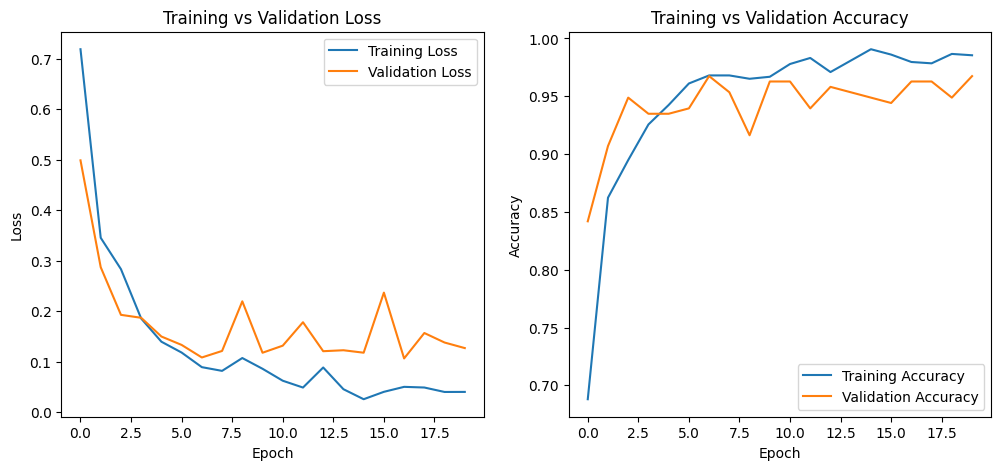

In [6]:
import matplotlib.pyplot as plt

# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [7]:
# Evaluasi model dengan test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9555 - loss: 0.1101
Test accuracy: 0.96
Test loss: 0.09


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Ambil class_names dari dataset training
class_names = full_dataset.class_names  # Ambil nama kelas dari dataset training

# Fungsi untuk memprediksi gambar baru dan menampilkan hasil prediksi
def predict_image_with_display(image_path, model, img_size=(128, 128)):
    # Memuat gambar dan mengubah ukurannya sesuai dengan model input
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)  # Mengubah gambar menjadi array
    img_array = tf.expand_dims(img_array, 0)  # Menambahkan batch dimension

    # Melakukan prediksi dengan model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Mengambil kelas dengan probabilitas tertinggi
    confidence = np.max(predictions[0])  # Mengambil nilai probabilitas tertinggi

    # Menampilkan gambar dan hasil prediksi
    plt.imshow(img)  # Menampilkan gambar
    plt.axis('off')  # Menyembunyikan axis
    plt.title(f"Prediksi: {class_names[predicted_class]}\nConfidence: {confidence*100:.2f}%")
    plt.show()

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


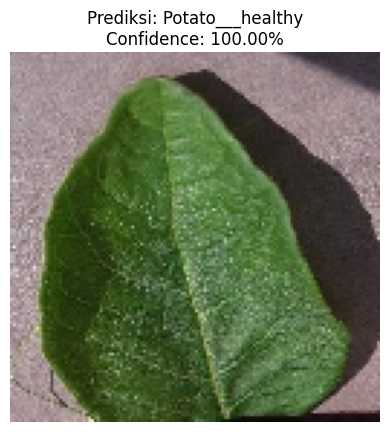

In [12]:
image_path = 'D:\\Semester 6\\AI\\Artificial_Inteligence\\new_images\\Potato_healthy.jpg' 

predicted_index, confidence = predict_image_with_display(image_path, model)